# Classification by universal-sentence-encoder-multilingual_Large for 5-class-Consumer-Complaints


## 1.Import library

In [ ]:
!pip3 install tensorflow_text>=2.0.0rc0

In [ ]:
!pip install pandas_summary

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import time
import seaborn as sns

np.random.seed(10)

tf.__version__

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.2.0'

## 2. Import text data 

In [ ]:
import pandas as pd
df = pd.read_csv('Consumer_Complaints.csv')
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,6,11,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,04/17/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,"Medical Data Systems, Inc.",VA,245XX,NaN,Consent not provided,Web,04/17/2019,Closed with explanation,Yes,NaN,3214574
1,04/17/2019,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,NaN,Company believes it acted appropriately as aut...,Forest Recovery Services LLC,FL,33705,NaN,Consent not provided,Web,04/17/2019,Closed with explanation,Yes,NaN,3215174
2,04/17/2019,Vehicle loan or lease,Loan,Managing the loan or lease,Billing problem,NaN,NaN,ALLY FINANCIAL INC.,MD,210XX,NaN,NaN,Web,04/17/2019,In progress,Yes,NaN,3214495
3,04/17/2019,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,NaN,NaN,AES/PHEAA,NY,113XX,NaN,NaN,Web,04/17/2019,Closed with explanation,Yes,NaN,3214324
4,04/17/2019,Debt collection,I do not know,Written notification about debt,Notification didn't disclose it was an attempt...,NaN,NaN,"Security Credit Services, LLC",TX,770XX,Servicemember,NaN,Web,04/17/2019,Closed with explanation,Yes,NaN,3215140


In [ ]:
from pandas_summary import DataFrameSummary
DataFrameSummary(df).summary()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.26424e+06
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.91138e+06
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,958936
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.10815e+06
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.09669e+06
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.78083e+06
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.21557e+06
counts,1264239,1264239,1029073,1264239,735512,380110,439905,1264239,1245618,1151723,173098,680248,1264239,1264239,1264233,1264239,768503,1264239
uniques,2694,18,76,167,218,363640,10,5254,63,22494,3,4,6,2643,8,2,2,1264239


## 3. Preparing data for classification

In [ ]:
df.dropna(subset=['Consumer complaint narrative'],inplace=True)

In [ ]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
17736,03/15/2019,Debt collection,Mortgage debt,Attempts to collect debt not owed,Debt was paid,XX/XX/XXXX - called Rushmore Loan Management S...,Company has responded to the consumer and the ...,RUSHMORE LOAN MANAGEMENT SERVICES LLC,LA,700XX,NaN,Consent provided,Web,03/21/2019,Closed with explanation,Yes,NaN,3180696
19557,03/13/2019,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,Upon looking at my credit file in XXXX of XXXX...,Company believes it acted appropriately as aut...,Perfection Collection,NC,286XX,NaN,Consent provided,Web,03/13/2019,Closed with explanation,Yes,NaN,3177880
20568,03/12/2019,Mortgage,Conventional home mortgage,Struggling to pay mortgage,NaN,Unlawful foreclosure. I have submitted a full ...,Company believes it acted appropriately as aut...,Quality Loan Service Corporation,CA,922XX,NaN,Consent provided,Web,03/12/2019,Closed with explanation,Yes,NaN,3176549
21777,03/11/2019,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,Upon opening up a Wells Fargo checking account...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,NJ,077XX,NaN,Consent provided,Web,03/12/2019,Closed with explanation,No,NaN,3176364
21791,03/11/2019,Debt collection,Medical debt,Written notification about debt,Didn't receive enough information to verify debt,I XXXX XXXX has got into contact with XXXX ( X...,Company has responded to the consumer and the ...,"HCFS Health Care Financial Services, Inc.",AL,NaN,Servicemember,Consent provided,Web,03/11/2019,Closed with explanation,Yes,NaN,3175399


In [ ]:
DataFrameSummary(df).summary()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380110
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.43348e+06
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,529526
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.29016e+06
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.02061e+06
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.57573e+06
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.87375e+06
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.1807e+06
counts,380110,380110,327937,380110,266914,380110,181598,380110,378734,292121,65569,380110,380110,380110,380106,380110,164076,380110
uniques,1456,18,75,161,215,363640,10,4108,63,9984,3,1,1,1463,5,2,2,380110


In [ ]:
df['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    91204
Debt collection                                                                 85731
Mortgage                                                                        52691
Credit reporting                                                                31588
Student loan                                                                    21580
Credit card or prepaid card                                                     21061
Credit card                                                                     18838
Bank account or service                                                         14885
Checking or savings account                                                     12686
Consumer Loan                                                                    9474
Vehicle loan or lease                                                            5634
Money transfer, virtual currency, or money service    

Choose 5 products

In [ ]:
df2=df.query("Product in ['Student loan','Consumer Loan','Checking or savings account','Credit card','Bank account or service']")

In [ ]:
df2.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
22856,03/09/2019,Checking or savings account,Checking account,Managing an account,Fee problem,"On Saturday XX/XX/XXXX, I attempted to make an...",Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,300XX,NaN,Consent provided,Web,03/12/2019,Closed with explanation,Yes,NaN,3174502
23893,03/08/2019,Checking or savings account,Other banking product or service,Managing an account,Problem accessing account,I tried to go onto the website ( again ) after...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",CA,913XX,NaN,Consent provided,Web,03/12/2019,Closed with explanation,Yes,NaN,3173512
24907,03/07/2019,Checking or savings account,Other banking product or service,Managing an account,Problem making or receiving payments,Banks website malfunction cause my checks to b...,Company has responded to the consumer and the ...,U.S. BANCORP,WI,532XX,NaN,Consent provided,Web,03/07/2019,Closed with explanation,Yes,NaN,3172686
25244,03/06/2019,Student loan,Private student loan,Struggling to repay your loan,Can't get other flexible options for repaying ...,I had to take off school for financial purpose...,Company believes it acted appropriately as aut...,SLM CORPORATION,TX,794XX,NaN,Consent provided,Web,03/08/2019,Closed with monetary relief,Yes,NaN,3171599
25855,03/05/2019,Checking or savings account,Checking account,Closing an account,Company closed your account,I opened a Bank account with BB & T ( XX/XX/20...,Company has responded to the consumer and the ...,BB&T CORPORATION,GA,30345,NaN,Consent provided,Web,03/05/2019,Closed with explanation,Yes,NaN,3170198


In [ ]:
DataFrameSummary(df2).summary()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77463
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.21194e+06
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,501754
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.29024e+06
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.81851e+06
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.21763e+06
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.58772e+06
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.1745e+06
counts,77463,77463,58625,77463,34252,77463,31898,77463,77100,58271,11924,77463,77463,77463,77463,77463,54346,77463
uniques,1451,5,16,70,75,77255,10,1086,62,4141,3,1,1,1453,5,2,2,77463


In [ ]:
df2['Product'].value_counts()

Student loan                   21580
Credit card                    18838
Bank account or service        14885
Checking or savings account    12686
Consumer Loan                   9474
Name: Product, dtype: int64

In [ ]:
df3=df2.loc[:, ["Consumer complaint narrative","Product"]]
df3.head()

,Consumer complaint narrative,Product
22856,"On Saturday XX/XX/XXXX, I attempted to make an...",Checking or savings account
23893,I tried to go onto the website ( again ) after...,Checking or savings account
24907,Banks website malfunction cause my checks to b...,Checking or savings account
25244,I had to take off school for financial purpose...,Student loan
25855,I opened a Bank account with BB & T ( XX/XX/20...,Checking or savings account


In [ ]:
df4=df3.rename({'Consumer complaint narrative':'sentence'},axis='columns')
df4.head()

,sentence,Product
22856,"On Saturday XX/XX/XXXX, I attempted to make an...",Checking or savings account
23893,I tried to go onto the website ( again ) after...,Checking or savings account
24907,Banks website malfunction cause my checks to b...,Checking or savings account
25244,I had to take off school for financial purpose...,Student loan
25855,I opened a Bank account with BB & T ( XX/XX/20...,Checking or savings account


In [ ]:
from sklearn.preprocessing import LabelEncoder

lab = LabelEncoder()
lab = lab.fit(df4["Product"])
df4["Product"] = lab.transform(df4["Product"])
df4.head()

,sentence,Product
22856,"On Saturday XX/XX/XXXX, I attempted to make an...",1
23893,I tried to go onto the website ( again ) after...,1
24907,Banks website malfunction cause my checks to b...,1
25244,I had to take off school for financial purpose...,4
25855,I opened a Bank account with BB & T ( XX/XX/20...,1


Prepare for 500 samples

In [ ]:
n=500 
x=df4.sample(n, random_state=2)
x.head()

,sentence,Product
706377,My name is XXXX XXXX and this will be the seco...,4
226901,"These accounts from "" Transworld Systems '' sh...",4
862886,I had a vehicle on lease through Ally Financia...,2
592018,I have twice requested the number of days in e...,2
549583,When I graduated from school in XX/XX/2008 I w...,4


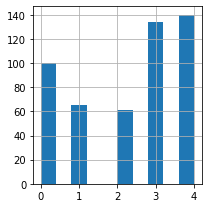

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 3, 3
x['Product'].hist(); 
plt.tight_layout() 
plt.show() 

*Column* of "sentence" is used as features and "product" is used as label 

In [ ]:
X=x.values[:,0]
print("X:",type(X))
print(np.shape(X))

X=X.tolist()
print(type(X))
print(len(X))
print(X[0:3])

X: <class 'numpy.ndarray'>
(500,)
<class 'list'>
500
['My name is XXXX XXXX and this will be the second time I am writing to complain about the unfair collection practices of Chase. I have XXXX student loans with them and I have to admit that I have been for the most part late on my payments. I always make the payments though late. The last complaint I had with them was resolved and hinged around the issue of notice before they defaulted me on my loans. This time I have been defaulted again still with no prior notice. I find this pattern unfair and somehow feel targeted. I accept I have been late on payments but I try and get caught up. I am really struggling with making payments and I have been told in the past that I do n\'t qualify for a forbearance or deferment which would have helped me get on track. \nOn XXXX XXXX, 2016 I called XXXX XXXX which is the recovery group I have been calling when late on my payments. I was on the phone with a specialist for about 13 mins and I have pho

In [ ]:
Y=x.values[:,1]
print("Y:",type(Y))
print(np.shape(Y))

Y=Y.tolist()
print(type(Y))
print(len(Y))
print(Y[0:5])

Y: <class 'numpy.ndarray'>
(500,)
<class 'list'>
500
[4, 4, 2, 2, 4]


## 4. Universal Sentence Encoder is used to extract features from texts

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"

!pip install --quiet tf-sentencepiece
import tensorflow_text

In [ ]:
# Import the Universal Sentence Encoder from TFHub
embed = hub.load(module_url)

# Compute a representation for X
messages = X
    
t=time.time()

message_embeddings = embed(messages)
for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    message_embedding_snippet = ", ".join((str(x) for x in message_embedding[:3]))

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')
   

85.14344 Seconds to predict


In [ ]:
print(type(message_embeddings))
print(np.shape(message_embeddings))
print((message_embeddings))

<class 'tensorflow.python.framework.ops.EagerTensor'>
(500, 512)
tf.Tensor(
[[-2.5878599e-02  8.3389483e-02  2.5516981e-02 ... -1.4638860e-04
  -3.8860116e-02  2.1402808e-02]
 [-7.5431935e-02 -4.5617077e-02  7.6779261e-02 ... -4.4794865e-02
  -1.9224826e-02 -3.0352535e-02]
 [ 5.8623566e-03 -1.9895693e-02  3.5201374e-02 ... -3.3397026e-02
   4.9753390e-02 -4.9126156e-02]
 ...
 [-9.6368082e-02 -9.5009759e-02  1.0072666e-02 ...  7.5803012e-02
   1.2399941e-01 -1.5572163e-02]
 [-4.0582076e-02  7.9401396e-02  5.3315450e-02 ...  1.8659776e-02
   3.7910700e-02 -3.7551599e-03]
 [-3.7590899e-02  2.9063178e-02  2.2135228e-02 ... -5.7195615e-02
   5.0680008e-02  7.6713324e-05]], shape=(500, 512), dtype=float32)


## 5. Train the classifier with 400 samples


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

X=message_embeddings
Y=Y

model = Sequential()
model.add(Dense(16, input_dim=512, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                8208      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 8,293
Trainable params: 8,293
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(type(X))
print(np.shape(X))
print(X.dtype)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(500, 512)
<dtype: 'float32'>


In [ ]:
Y = np.array(Y, dtype=np.float32)

print(type(Y))
print(np.shape(Y))
print(Y.dtype)

<class 'numpy.ndarray'>
(500,)
float32


In [ ]:
t=time.time()

optimizer=tf.keras.optimizers.Adam(1e-3)

filepath='CC2020.{epoch:02d}-{val_acc:.2f}.hdf5'
mc_cb = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max')


model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['acc'])

history = model.fit(X, Y, epochs=100, batch_size=32, validation_split=0.2, callbacks=[mc_cb])

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

Epoch 1/100
 1/13 [=>............................] - ETA: 0s - loss: 1.6202 - acc: 0.1250
Epoch 00001: val_acc improved from -inf to 0.45000, saving model to CC2020.01-0.45.hdf5
13/13 [==============================] - 0s 23ms/step - loss: 1.5973 - acc: 0.2650 - val_loss: 1.5685 - val_acc: 0.4500
Epoch 2/100
 1/13 [=>............................] - ETA: 0s - loss: 1.5605 - acc: 0.4375
Epoch 00002: val_acc improved from 0.45000 to 0.52000, saving model to CC2020.02-0.52.hdf5
13/13 [==============================] - 0s 5ms/step - loss: 1.5456 - acc: 0.4925 - val_loss: 1.5281 - val_acc: 0.5200
Epoch 3/100
 1/13 [=>............................] - ETA: 0s - loss: 1.5230 - acc: 0.4375
Epoch 00003: val_acc improved from 0.52000 to 0.54000, saving model to CC2020.03-0.54.hdf5
13/13 [==============================] - 0s 5ms/step - loss: 1.4921 - acc: 0.5450 - val_loss: 1.4798 - val_acc: 0.5400
Epoch 4/100
 1/13 [=>............................] - ETA: 0s - loss: 1.5054 - acc: 0.4688
Epoch 00004:

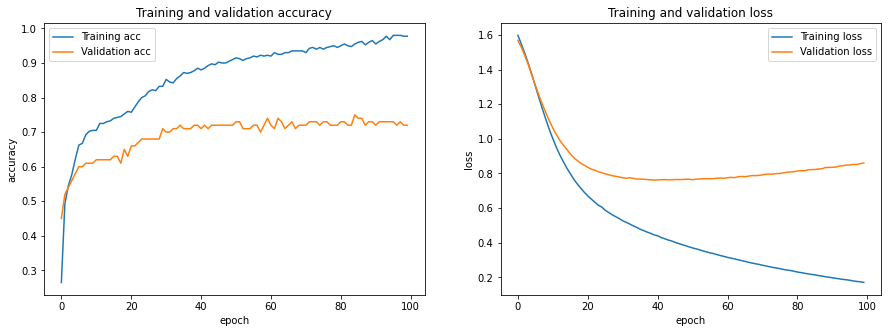

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
            
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show()

## 6. Confirm accuracy with Japanese text data

In [ ]:
!pip install --quiet tf-sentencepiece
import tf_sentencepiece  # Not used directly but needed to import TF ops

In [ ]:
JX=['当初、私はDodge ChargerをAlly Financialからリースしましたが、条件はかなり合理的と思われました。 それが、Allyが顧客フレンドリーになるのをやめたときです。 私は2013年に財政的に困難な状況を経験しました。通信回線がアップし、支払いがタイムリーに行われていることを確認する支払いについて、常にアリーと連絡を取り合っていました。 \ nリースの支払いに{$ 2000.00}近くを送った後、アリーは車を車道から差し戻しました！ アリーは評判の良い会社だと思って、私は完全にショックを受けました。 そうではない！ 私がようやくカスタマーサービスマネージャーに電話をかけたとき、彼女は不正直で失礼で非常に無礼でした。', 'XXXXで開設された当座預金口座、30日間保管された{$ 15000.00}デポジット、45日以内の{$ 250.00}デビット購入など、必要なすべてのプロモーション活動を満たし、5か月以上アカウントが開設され、{$ 300.00} 約束されたプロモーションボーナス。 何度か呼ばれ、監督者に話しかけた。 XXXX XXXXによるボーナスを約束しました。 シティバンクが彼らの言葉を守るのを手伝ってください。','私がオートローンを申請したとき、ローン会社は私の信用報告書にある未払いのVA Medical請求書を考慮に入れましたが、これは私の責任ではありません。 したがって、彼らがローンを拒否したとき、XXXXの退役軍人として私を差別しました。','yの名前はXXXXです。SynchronyBankについて不平を言うためにこの手紙を書いています。シンクロニー銀行が発行したサムズクラブのクレジットカードを持っています。私はそれを数回しか使用せず、その上に小さなバランスを持ちました。私は紙も電子請求書も受け取りませんでしたが、XXXXでは、その小さな残高をログオンして支払いを完了できました。当時、私はカードが無効化されたことを知りませんでしたが、明らかにそうでした。 Synchrony Bankは、チップが入っていない新しいXXXXを郵送したため、カードを無効にしたことを通知しました。私はサムでカードを使用しようとしたときにこれについて知りました。 sクラブが購入代金を支払う。多くの試みが失敗し、非協力的で失礼なSynchrony Bankの顧客担当者に対処した後、自宅の電話も携帯電話もSychrony Bankのセキュリティ要件を満たしていないため、カードを再アクティブ化できないと言われました。 Synchrony Bankは私の夫の名前で携帯電話を拒否しました。インターネットベースであるため、彼らは私の自宅の電話を拒否しました。 Synchrony Bankが過去に、アカウントを取得するために自分の名前で固定電話または携帯電話を所有する必要があると言ったことはないことに注意してください。この規則を初めて聞いたのは、カードに関するこの問題が発生したときでした。私はSynchrony Bankの本社に連絡し、自宅の住所を確認できるようにライセンスをFAXする以外に選択肢がないと言った消費者サービス担当者に話を聞きました。私はこれをこれまで一度も受けたことがなく、手順全体が不規則であることがわかりましたが、そうしました。二回毎回、Synchrony BankはXXXX部門が暗すぎてライセンス番号を読み取れないと主張しました。私はXX / XX / XXXX以降同じ住所に住んでいます。 XX / XX / XXXX以降同じ電話番号を持っています。私は、自宅の住所、自宅の電話番号、携帯電話番号を使用して、他の金融機関と問題なく取引しています。 Synchriony Bankは私の夫の名前の下にあるため、私の携帯電話番号を受け入れることを拒否しました。インターネット経由で接続されているため、彼らは私の自宅の電話番号を拒否しました。私は不当に標的にされていると感じており、私が不平を言ったのでこれは報復だと感じています。 XX / XX / XXXXにこのカードを支払いました。使用できるはずです。ライセンスを2回FAXで送信しましたが、読むことができないと主張しています。私は法を遵守する市民です。私の情報は簡単に検証できます。 Synchrony Bankのポリシーでは、アカウントを維持するために電話を自分の名前で登録する必要があるとは決して述べていません。それでも、彼らは私の携帯電話が夫の名前の下にあるため、私が支払ったカードの使用を拒否していますか？自宅の電話はインターネット経由で接続されているのですか？これは合法ですか？彼らは私のライセンスをファックスするように私に頼みました、そして私はしました。二回！それでもカードを使用できませんでした。実際、彼らは新しいカードを送信することすら提案していません。なし。他の会社のカードがあり、必要に応じて、携帯電話または自宅の電話で連絡があります。私はSynchrony Bankから受けたような治療を受けたことがないので、その理由を知りたいと思っています。私は逃げ回っています。他のアクティブなクレジットカードはありますが、私は資格があるので、公正で倫理的な扱いに対する権利を主張したいと思います。彼らが私に対してしていることは間違っており、正当化することはできません。他の金融機関との一貫した定期的な関係を維持しているときではありません。現在のところ、私はまだ自分のカードを使用できるように戦っています。私がSynchrony Bankから最後に聞いたのは、実際にXX / XX / XXXXの2週間目で、自宅の電話にメッセージを残して、まだライセンスを読めないことを知らせて、もう一度FAXするように頼みました。三回目。それは私があなたに連絡することにしたときです。この問題の解決にご協力ください。 \ nこの問題にご関心をお寄せいただきありがとうございます。 \ nXXXX', 'XXXX、XXXX、2010でGapクレジットカードを開きました。長年の支払い履歴がありましたが、XXXX、XXXXに移動してすぐに、新しい住所を通知したにもかかわらず、XXXX XXXXに請求書を送っていました。私の母の名前、XXXX。私は彼らにこの問題について何度も何度も連絡を取り、以前彼らに対して苦情を提出していました。私は彼らと協力してみましたが、彼らは私の支払いをオンラインで行うように促しましたが、私はすべてのアカウントに小切手を支払ったと説明し、彼らのオンラインプラットフォームを使って支払いをすることに不安を感じました。私の住所を訂正し、声明を家に送ろうとする試みが何度かありました。毎回、担当者は問題が修正されたことを保証しましたが、その後、私は私の声明を受け取ることはありませんでした。最後に、彼らは私のアカウントを閉鎖していると言って私に連絡した。このアカウントには5年以上の履歴があり、良い制限がありますが、これらはすべて私のクレジットスコアに適していました。一部の支払いを逃したために彼らは私のアカウントを閉鎖しましたが、彼らは私にそれらを送らなかったのでそれらの支払いを逃しました、そして私はそれらをレビューできませんでした。このアカウントを閉鎖すると、私の信用履歴に悪影響を及ぼしました。アカウントが閉鎖されたので、彼らはようやく私のステートメントを正しい場所に送る方法を見つけました。そして、これが問題になる前に、私はいつものように時間通りに支払いました。', 'プロモーションコードXXXXでCitigold当座預金口座を開設しました。これは、XXXX XXXX XXXX XXXXマイルを連続した月にXXXXの請求書の支払いを行い、対応するデビットカードを使用した購入で{$ 1000.00}を獲得しました（口座開設から60日以内にXXXX）要件を完了した後、XXXX / XXXX / 2016のシティオンラインチャット担当者 "XXXX \ に確認し、アカウントの要件を満たしていることを通知しました。XXXXは、 XXXX / XXXX / 2016でマイルが転記されたはずであるということを意味します。XXXX/ XXXX / 2016の時点でマイルを受け取っていないので、ステータスを別のオンラインチャット。シティ代表 XXXXは、内部調査調査を開始すると述べました。この調査が完了するまでに24日間のばかげた時間がかかりました（XXXX / XXXX / 2016）。彼らの研究の結果は、私が必要な時間内に必要なデビットカードの購入をしなかったと主張しました。これは間違っているだけではありません（アカウントアクティビティを再確認し、口座開設から60日以内にデビットカードで{$ 1000.00}以上を行ったことを確認しました）だけでなく、これはシティ代表がXXXXで私に言ったことと矛盾しています/ XXXX / 2016で、すべての資格要件を完了したことが確認されました。さらに、マイルを授与するのではなく、XXXX / XXXX / 2016で必要なデビットカードの購入を行ったことに応答して確認することにより、XXXXにこのプロモーションを成功させる最後の機会を与えたとき、彼らは別の調査を開くと述べました.. 。これにはおそらく別のとんでもない時間がかかります。シティは嘘をついているか、またはこれらの資格要件を完了し、このボーナスの資格があることを証明する記録がないことを望んでいます。私はプロモーションのすべての条件を完了し、彼らはこれを私に確認しましたが、彼らは遅らせ、遅らせ、遅らせました。私は彼らが私が単にこれを忘れて手放すことを望んでいるだけだと思うことができます、しかし、これらの習慣は不誠実で非常に失望します','XXXXまたはXXXX、XXXXについて、バークレイクレジットカードの承認を受けました。私が応募したとき、私はXXXXの異なるカードを比較して、0％の利子を提供していました。 \ n14か月間、バークレイカードは0％の利息を提供し、私はそれに決めました。 \ nクレジット限度額{$ 2000.00}が承認され、条件が記載されたメールを受け取ると言われました。そのメールを受け取ったことはありません。 \ n最初の請求明細書には、予想どおり、請求される利息はありませんでした。 \ nただし、2回目の請求明細書には{$ 25.00}の関心が示されました。 \ n3番目の請求書には、{$ 3200.00}の関心が示されました。 \ n残高が先月より少なかったとしても、4番目の請求明細書には{$ 34.00}の関心があります。 \ nこれは間違いなく「餌とスイッチ」の申し出でした。私は通常、オンラインで行った申し出や購入の条件を印刷しましたが、バークレイからその機会を与えられず、メールを受け取ると言われました。 \ nしかし、彼らは私が「承認された\ と告げる以外は何もしなかった。電子メールでも普通郵便でも条件を受け取りませんでした。 苦情を申し立てたとき、私は確かに24.99％の利息に同意したと確信しました。このレートでこのカードを申請したことすらありませんでした。私はすぐにカードをキャンセルしました。私はそれを必要としなかったし、0％でいくつかの家の改造をし、そして私の他のカードからのバランスの移動をするためにだけ適用された。今、私はXXXXカードの支払いにこだわっています。バークレイカードは、私が通常使用しているXXXX XXXXとほぼ同じXXXXの利率を持っています。これまでのところ、この偽/虚偽の広告は、XXXX XXXX、XXXXから{$ 0.00}になるはずだったXXXX 2月まで、{$ 92.00}かかりました。私は、利子の請求を示す声明を添付しようとしましたが、できませんでした。必要に応じて提供します。ありがとうございました。' ,'これは月曜日のメモのフォローアップです。XXXXXXXX XX / XX / XXXXは以下にあります。 \ n \ n今日、XXXX XXXX XX / XX / XXXX @ XXXX XXXXもう一度クレジットレポートを確認しましたが、ここで取り上げられている問題に関するクレジットレポートの変更はありません。私は、私の未払いの支払い履歴のために、シティによって50万ドル以上のクレジットが延長されました。これは、ビューローへの信用報告では反映されておらず、私の信用にマイナスの影響を及ぼしています。現在、私はXXXX / XXXX / XXXX以降「オープン回転条件を表示しています。私の支払いステータスは不明として表示されます。私の残高は空白です（ただし、残高はありません）およびクレジット制限、金額の期限クレジットカードの明細書には{$ 50000.00}（XXXX）を超える利用可能クレジットが表示され、クレジットレポートには反映されていません。したがって、クレジットスコアまたはクレジットワージネスの公正かつ正確な評価を提供していません。 。私はシティに半ダース以上連絡を取り、彼らはそれを報告していると私に言い続けています。信用情報局の主張は情報が提供されているものから正確に反映されているということです。 \ n \ nXXXX月曜日、XXXX XXXX XXXX消費者金融保護XXXX XXXX XXXX、XXXX XXXX DC。XXXX RE：シティ＆信用管理部門への正式な苦情懸念される可能性がある、過去数年にわたり、私は私のシティクレジットカード私の信用報告書で報告されていないアカウント。以前に複数回提供されたものとまったく同じ情報であり、添付ファイルに示されているとおりの正確で正確な情報を報告することができませんでした。 \ n \ n複数の手紙を書いて、通信を認証し、12回以上電話をかけましたが、実際に私を助けることができる人はいません。サービス担当者にアカウントのメモを文書化するように依頼しました。 XXXXが顧客として退社した後でも、電話で誰かに話をしてもらうことすらできないようです。現在、私のクレジットにマイナスの影響を与えているため、これは報告することが重要です。報告されないままでいると、残りの勤務年数にわたって利子費用が数十万ではないとしても、数千の費用がかかる可能性があります。 \ n \ n再度、シティは「口座開設」を表示しますが、24か月の履歴、クレジット残高、利用可能なクレジット制限、または支払いが期限内に表示されないため、正確に報告されません。これらはすべて、クレジットスコアリングに大きな影響を与えます。 \ n \ nもう一度この手紙を検討してください。この問題に対する別の正式なリクエストをすぐに調査し、アカウントの存続期間を反映して不正確な情報に対処し、修正します。これにより、私の真の信用履歴とその後のスコアがXXXXメジャーに反映されます全国信用調査機関。' ,'エランファイナンシャルサービスクレジットカードペイメントサービスのウェブサイトには、「今日の日付と等しい支払日を持つ支払は、XXXX XXXX。CT。以降は変更または削除できません。 私はスーパーバイザーに電話して、カットオフ時間は本当にXXXX XXXXであると伝えました。XXXXXXXXでのカットオフはWebサイト上の虚偽の声明であり、午後XXXXではなくXXXXで遅延料金を評価しているため修正が必要です','Bank of New York Mellonは、Heath Savings Accountを提供しています。 彼らのウェブサイトでは、銀行または信用組合からHSAアカウントに電子的に入金するための電子送金を提供しています。 2015年XXXX XXXXにあるBank of New York Mellon HSAウェブサイトを使用して、HSAにEFT預金を行いました。個人の銀行口座は2015年にXXXX XXXXに引き落とされました。 今日、XXXX XXXX、2015年現在、ニューヨークメロン銀行のHSAアカウントには、XXXX日間資金があったにもかかわらず、EFT預金は反映されていません。']

In [ ]:
t=time.time()

# Compute a representation for JX
messages = JX

message_embeddings = embed(messages)
for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    message_embedding_snippet = ", ".join((str(x) for x in message_embedding[:3]))

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')   

1.76038 Seconds to predict


In [ ]:
print(type(message_embeddings))
print(message_embeddings.shape)
print(message_embeddings)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(10, 512)
tf.Tensor(
[[-0.04333587 -0.01157983  0.00114581 ...  0.00729112  0.10936303
  -0.02238163]
 [-0.02250585 -0.01300601 -0.01814105 ...  0.03179115 -0.0003681
  -0.01808646]
 [ 0.0767968   0.0609981   0.02081919 ... -0.02414167 -0.00870492
   0.00672941]
 ...
 [-0.07515837  0.07559213  0.06502892 ... -0.05720684 -0.03678658
  -0.06044804]
 [-0.0346632   0.05349241 -0.00329141 ...  0.0041291  -0.02322101
   0.07745281]
 [ 0.00542419  0.00867969  0.04771839 ... -0.00377697  0.05913667
  -0.04127851]], shape=(10, 512), dtype=float32)


In [ ]:
t=time.time()

pre=model.predict(message_embeddings)

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

print(pre)

   

0.12606 Seconds to predict
[[3.76376929e-03 7.59604678e-04 9.78717804e-01 1.25228921e-02
  4.23585810e-03]
 [7.36530781e-01 2.45581672e-01 6.11072639e-03 1.15664005e-02
  2.10498707e-04]
 [1.01677410e-03 2.82757170e-03 4.75640982e-01 1.15164015e-02
  5.08998334e-01]
 [1.90495308e-02 1.64470654e-02 3.04341130e-03 9.60990727e-01
  4.69254126e-04]
 [1.14042626e-03 1.81001509e-04 2.50667520e-03 9.85188723e-01
  1.09832184e-02]
 [4.04910505e-01 3.27933580e-02 4.15959693e-02 5.20108104e-01
  5.92038268e-04]
 [1.83604064e-03 9.90214641e-04 1.92989018e-02 9.76232767e-01
  1.64200889e-03]
 [6.40835031e-04 1.83534023e-04 2.99798138e-03 9.91284251e-01
  4.89342911e-03]
 [1.14334587e-04 1.90464722e-04 2.73659127e-03 9.96806741e-01
  1.51879809e-04]
 [8.24606061e-01 1.33404538e-01 2.02375604e-03 3.98078337e-02
  1.57724164e-04]]


In [ ]:
prediction=np.argmax(pre, axis=-1)
prediction

array([2, 0, 4, 3, 3, 3, 3, 3, 3, 0])

JX right answer : [2, 1, 2, 3, 3, 0, 3, 3, 3, 0]

In [ ]:
list(lab.inverse_transform(prediction))

['Consumer Loan',
 'Bank account or service',
 'Student loan',
 'Credit card',
 'Credit card',
 'Credit card',
 'Credit card',
 'Credit card',
 'Credit card',
 'Bank account or service']

This code is solely for educational purpose. The code cannot be used for investments or busineeses in practice. TOSHI STATS Co.,Ltd. and I do not accept any responsibility or liability for loss or damage occasioned to any person or property through using materials, instructions, methods, algorithm or ideas contained herein, or acting or refraining from acting as a result of such use. TOSHI STATS Co.,Ltd. and I expressly disclaim all implied warranties, including merchantability or fitness for any particular purpose. There will be no duty on TOSHI STATS Co.,Ltd. and me to correct any errors or defects in the codes and the software.¶